- n : 상태 변수의 개수
- m : 측정 변수의 개수
- x : 상태 벡터, (n, 1)
- y : 측정 벡터, (m, 1)
- A : 상태전이행렬 (n, n) x를 다음 시간의 x로 변환
- C : 측정행렬 (m, n) x를 y로 변환
- P : 오차공분산행렬 (n, n) x의 불확실성
- Q : 프로세스 잡음 공분산 (n, n) 시스템 자체 불확실성
- R : 센서의 잡음 (m, m)
- K : kalman gain (n, m), 예측과 측정 사이 가중치

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.linalg import block_diag
import time

In [ ]:
# 1. setting, n개의 도시 날씨를 예측하는데, m개의 도시에만 관측소가 있다고 상상. 
n = 100 # 상태 변수
m = 20  # 측정 변수
timesteps = 150

# A : 대부분 독립적으로, 2개는 강하게 연관되도록 회전
A_independent = 0.99*np.identity(n-2)
theta = np.pi/15
A_correlated = 0.99*np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]]) # 반시계 thate 회전
A = block_diag(A_independent, A_correlated)


In [8]:
A

array([[ 0.99      ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.99      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99      , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.99      ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.96836612, -0.20583257],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.20583257,  0.96836612]], shape=(100, 100))

In [ ]:
C = np.zeros((m, n))
C[:m, :m] = np.identity(m) # m개만 관측할 수 있다고 가정했고, n-m개는 간접적 추정.

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(20, 100))

In [11]:
# NOISE
Q = np.identity(n) * 0.05
R = np.identity(m) * 0.1

In [ ]:
# 2. 실제 시스템과 측정 데이터 생성해놓기
x_true = np.zeros((n, timesteps)) 
y_meas = np.zeros((m, timesteps)) 

x_true[:, 0] = np.random.randn(n) * 2
y_meas[:, 0] = C @ x_true[:, 0] + np.random.multivariate_normal(np.zeros(m), R)
# https://runebook.dev/ko/docs/numpy/reference/random/generated/numpy.random.multivariate_normal
# C @ x_true[:, 0]까지는 이상적인 측정값. 그 이후 값은 잡음

for k in range(1, timesteps):
    x_true[:, k] = A @ x_true[:, k-1] + np.random.multivariate_normal(np.zeros(n), Q) # 실제 상태
    y_meas[:, k] = C @ x_true[:, k] + np.random.multivariate_normal(np.zeros(m), R) # 관측값(노이즈로 오염되어 있다.)

In [17]:
x_true, y_meas

(array([[ 3.51174489,  3.7437322 ,  3.63916217, ...,  3.01833581,
          2.97017776,  3.27470975],
        [-3.25808824, -2.97888845, -3.12712394, ...,  1.18888976,
          1.10626907,  1.07276311],
        [-2.59325524, -2.87759435, -2.86674882, ..., -0.7916133 ,
         -0.63470261, -0.64959868],
        ...,
        [-2.19745561, -2.49657201, -2.39021666, ..., -0.04115159,
         -0.25565361, -0.25256353],
        [ 4.7567201 ,  4.37490565,  4.04621609, ...,  0.013395  ,
          1.1964674 ,  1.8129467 ],
        [ 0.71155424,  1.49915376,  2.22683991, ..., -2.58073096,
         -2.07261686, -1.35066203]], shape=(100, 150)),
 array([[ 3.62616729,  3.58115085,  3.43965131, ...,  2.74701494,
          3.16731218,  2.97090276],
        [-3.59763744, -3.36575625, -2.85227875, ...,  1.61212125,
          1.30625464,  1.53075629],
        [-1.9311148 , -2.92731531, -3.13975347, ..., -0.79974615,
         -0.62483911, -0.63828776],
        ...,
        [-2.61786506, -2.51634025, -

In [18]:
# 3. standard kalman filter
def std_kalman_filter(y_meas, x0, p0, A, C, Q, R):
    #----------------초기화------------------------------
    n = A.shape[0]
    timesteps = y_meas.shape[1]
    x_est = np.zeros((n, timesteps))
    x_pred_step = x0
    p_pred_step = p0
    
    for k in range(timesteps):
        #-------------prediction------------------------
        x_pred = A @ x_pred_step # (100, 100) @ (100, 1)
        p_pred = A @ p_pred_step @ A.T + Q # (100, 100) @ (100, 100) @ (100, 100) + (100, 100)
        
        #-------------update----------------------------
        S = C @ p_pred @ C.T + R # 측정 공간에서의 불확실성 계산, (20, 100) @ (100, 100) @ (100, 20) + (20, 20)
        K = p_pred @ C.T @ inv(S) # (100, 100) @ (100, 20) @ (20, 20)
        x_est[:, k] = x_pred + K @ (y_meas[:, k] - C @ x_pred)
        p_pred_step = (np.identity(n) - K @ C) @ p_pred
        x_pred_step = x_est[:, k]
    return x_est

In [25]:
# 4. Ensemble kalman filter
# 오차 공분산 P를 직접 계산하지 않고, N개의 앙상블 표본들을 이용해 근사.

def ensemble_kalman_filter(y_meas, x0, p0, N, A, C, Q, R):
    #-----------------초기화------------------
    n = A.shape[0]
    timesteps = y_meas.shape[1]
    x_est_mean = np.zeros((n, timesteps))
    # (100, 1) + (100, N) : Broadcasting -> (100, N)
    ensemble = x0[:, np.newaxis] + np.random.multivariate_normal(np.zeros(n), p0, N).T
    
    for k in range(timesteps):
        for i in range(N):
            # (100, 1) = (100, 100) @ (100, 1) + (100, 1) -> 전체 끝나면 (100, N)
            ensemble[:, i] = A @ ensemble[:, i] + np.random.multivariate_normal(np.zeros(n), Q)
        
        x_mean_pred = np.mean(ensemble, axis=1) # (100, 50) -> (100, 1)로 변경
        y_ensemble = C @ ensemble # (20, 100) @ (100, N) -> (20, N)
        y_mean = np.mean(y_ensemble, axis = 1) # (20, 1) 가상 측정값들의 평균
        p_xy = (ensemble - x_mean_pred[:, np.newaxis]) @ (y_ensemble - y_mean[:, np.newaxis]).T / (N - 1)
        p_yy = (y_ensemble - y_mean[:, np.newaxis]) @ (y_ensemble - y_mean[:, np.newaxis]).T / (N - 1)
        
        S = p_yy + R
        K = p_xy @ inv(S)
        
        for i in range(N):
            perturbed_y = y_meas[:, k] + np.random.multivariate_normal(np.zeros(m), R)
            ensemble[:, i] += K @ (perturbed_y - C @ ensemble[:, i])
            
        x_est_mean[:, k] = np.mean(ensemble, axis=1)
    return x_est_mean

In [27]:
# 5. simulation
x0 = np.zeros(n)
p0 = np.identity(n)

# standard KF
x_est_kf = std_kalman_filter(y_meas, x0, p0, A, C, Q, R)
error_kf = np.linalg.norm(x_true - x_est_kf, axis=0)
ensemble_sizes = [10, 30, 80]
errors_enkf = {}
x_est_enkf_dict = {}

for N in ensemble_sizes:
    print(f"N = {N}")
    x_est_enkf_dict[N] = ensemble_kalman_filter(y_meas, x0, p0, N, A, C, Q, R)
    errors_enkf[N] = np.linalg.norm(x_true - x_est_enkf_dict[N], axis=0)

N = 10
N = 30
N = 80


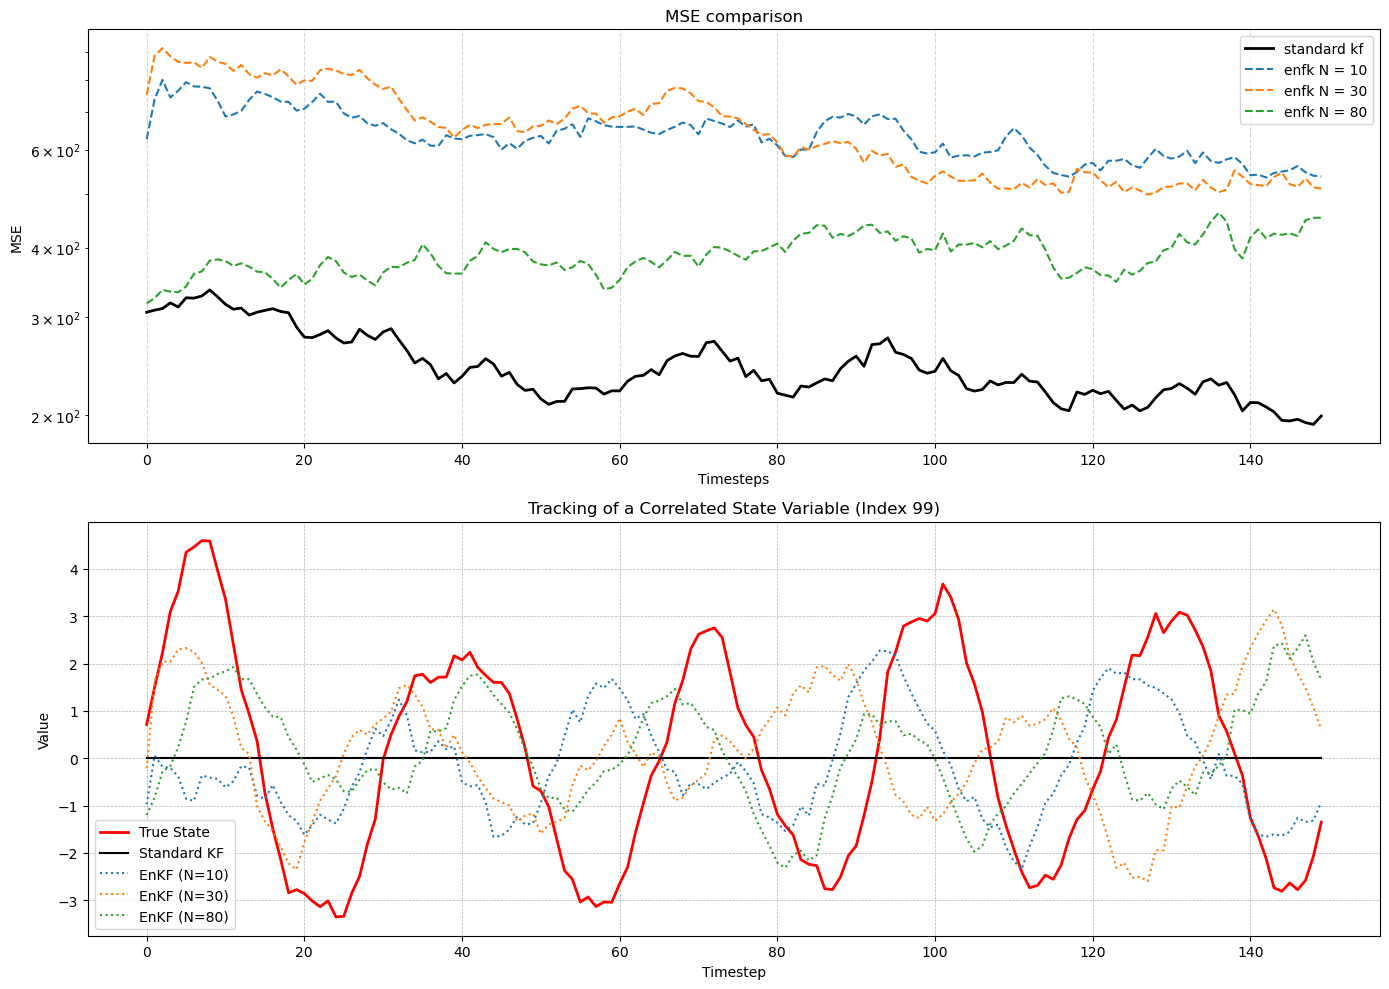

In [31]:
# plotting

plt.figure(figsize = (14, 10))
plt.subplot(2, 1, 1)
plt.plot(error_kf**2, label = 'standard kf', color='black', linewidth = 2)
for N in ensemble_sizes:
    plt.plot(errors_enkf[N]**2, label = f'enfk N = {N}', linestyle='--')
    
plt.title('MSE comparison')
plt.xlabel('Timesteps')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha = 0.5, linestyle='--')

correlated_idx = n - 1
plt.subplot(2, 1, 2)
plt.plot(x_true[correlated_idx, :], label='True State', color='red', linewidth=2)
plt.plot(x_est_kf[correlated_idx, :], label='Standard KF', color='black')
for N in ensemble_sizes:
    plt.plot(x_est_enkf_dict[N][correlated_idx, :], label=f'EnKF (N={N})', linestyle=':')
plt.title(f'Tracking of a Correlated State Variable (Index {correlated_idx})')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [32]:
# --- 7. [추가] 실제 고차원 성능 테스트 ---
print("\n--- High-Dimensional Performance Test ---")
n_high = 1000
m_high = 50
N_high = 100 # n >> N

# 고차원 시스템용 데이터 생성 (간략화)
A_h = 0.99 * np.identity(n_high)
C_h = np.zeros((m_high, n_high)); C_h[:m_high, :m_high] = np.identity(m_high)
Q_h = np.identity(n_high) * 0.05
R_h = np.identity(m_high) * 0.5
x0_h = np.zeros(n_high)
P0_h = np.identity(n_high)
y_meas_h = np.random.randn(m_high, timesteps)

# Standard KF 시간 측정
print(f"Running Standard KF with n={n_high}...")
start_kf = time.time()
try:
    _ = standard_kalman_filter(y_meas_h, x0_h, P0_h, A_h, C_h, Q_h, R_h)
    time_kf = time.time() - start_kf
    print(f"Standard KF execution time: {time_kf:.2f} seconds")
except Exception as e:
    print(f"Standard KF failed or is too slow. Error: {e}")


# EnKF 시간 측정
print(f"Running EnKF with n={n_high} and N={N_high}...")
start_enkf = time.time()
_ = ensemble_kalman_filter(y_meas_h, x0_h, P0_h, N_high, A_h, C_h, Q_h, R_h)
time_enkf = time.time() - start_enkf
print(f"EnKF execution time: {time_enkf:.2f} seconds")

if 'time_kf' in locals():
    print(f"\nEnKF was approximately {time_kf/time_enkf:.1f} times faster than Standard KF.")


--- High-Dimensional Performance Test ---
Running Standard KF with n=1000...
Standard KF failed or is too slow. Error: name 'standard_kalman_filter' is not defined
Running EnKF with n=1000 and N=100...


ValueError: mean and cov must have same length